In [1]:
import dill
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.transforms as transforms
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np

from scipy.stats import linregress

import trompy as tp

%matplotlib inline

In [2]:
# fig settings
scattersize=50
colors = ['darkturquoise','dodgerblue', 'darkblue']

In [4]:
datafolder = "C:\\Github\\Distraction-Paper\\data\\"
figfolder = "C:\\Github\\Distraction-Paper\\figs\\"
outputfolder = "C:\\Github\\Distraction-Paper\\output\\"

try:
    pickle_in = open(datafolder + "distraction_data_only_snips.pickle", 'rb')
except FileNotFoundError:
        print('Cannot access pickled file')

[modDict, disDict, habDict] = dill.load(pickle_in)

In [5]:
# thph2.8 removed from analysis because no data on habituation day

modDict.pop('thph2.8')
disDict.pop('thph2.8')
;

''

In [33]:
modalitykey = {'whitenoise':[1,4], 'tone':[2,5], 'combined3':[3,6]}


def get_trialtype_prob(daydict):
    """ Gets probility of being distracted divided into different trial types"""
    wn_prob, tone_prob, combined_prob = [], [], []

    rats = daydict.keys()
    for rat in rats:
        d = daydict[rat]

        wn = [L for L, tt in zip(d["d_bool_array"], d["trialtype"]) if (tt in [1,4])]
        wn_prob.append(sum(wn)/len(wn))

        tn = [L for L, tt in zip(d["d_bool_array"], d["trialtype"]) if (tt in [2,5])]
        tone_prob.append(sum(tn)/len(tn))

        comb = [L for L, tt in zip(d["d_bool_array"], d["trialtype"]) if (tt in [3,6])]
        combined_prob.append(sum(comb)/len(comb))
        
    return wn_prob, tone_prob, combined_prob

wn_prob, tone_prob, combined_prob = get_trialtype_prob(disDict)

def get_trialtype_auc(daydict, epoch=[60, 90], signal="filt_z"):
    
    wn_auc, tone_auc, combined_auc = [], [], []
    
    rats = daydict.keys()
    for rat in rats:
        d = daydict[rat]
        
        wn = [np.mean(snip[epoch[0]:epoch[1]]) for snip, tt in zip(d["snips_distractors"][signal], d["trialtype"]) if (tt in [1,4])]
        wn_auc.append(np.mean(wn))
        
        tone = [np.mean(snip[epoch[0]:epoch[1]]) for snip, tt in zip(d["snips_distractors"][signal], d["trialtype"]) if (tt in [2,5])]
        tone_auc.append(np.mean(tone))
        
        combined = [np.mean(snip[epoch[0]:epoch[1]]) for snip, tt in zip(d["snips_distractors"][signal], d["trialtype"]) if (tt in [3,6])]
        combined_auc.append(np.mean(combined))
        
    return wn_auc, tone_auc, combined_auc


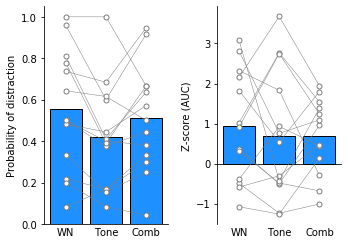

In [56]:
f, [ax1, ax2] = plt.subplots(ncols=2, figsize=(5.5,4))
f.subplots_adjust(left=0.15, wspace=0.4)

wn_prob, tone_prob, combined_prob = get_trialtype_prob(disDict)

_, barx, _, _ = tp.barscatter([wn_prob, tone_prob, combined_prob], paired=True,
              barfacecolor=[colors[1]], barfacecoloroption='same',
              scattersize=scattersize,
              ax=ax1)

wn_auc, tone_auc, combined_auc = get_trialtype_auc(disDict)

tp.barscatter([wn_auc, tone_auc, combined_auc], paired=True,
              barfacecolor=[colors[1]], barfacecoloroption='same',
              scattersize=scattersize,
              ax=ax2)

ax1.set_ylabel("Probability of distraction")
ax2.set_ylabel("Z-score (AUC)")

barlabels=['WN', 'Tone', 'Comb']

for axis in [ax1, ax2]:
    trans = transforms.blended_transform_factory(
                axis.transData, axis.transAxes)
    for x, label in zip(barx, barlabels):
        axis.text(x, -0.05, label, ha="center", transform=trans)
        
f.savefig(figfolder + "trialtype_bars.pdf")
    

In [97]:
import pandas as pd
from statsmodels.stats.anova import AnovaRM
from scipy import stats

rats = disDict.keys()
data = np.array([wn_prob, tone_prob, combined_prob], dtype="float").T


df = pd.DataFrame(data, columns=["wn", "tone", "comb"], index=rats)
df.insert(0, "ratid", rats)
df = df.melt(id_vars = "ratid")

aovrm = AnovaRM(df, "value", "ratid", within=["variable"])
res = aovrm.fit()

print(res)

print("Mean of WN is", np.mean(wn_prob))
print("Mean of Tone is", np.mean(tone_prob))
print("Mean of Comb is", np.mean(combined_prob))

t, p = stats.ttest_rel(wn_prob, tone_prob)
print('WN vs Tone', t, p, "Sidak:", tp.sidakcorr(p))

t, p = stats.ttest_rel(tone_prob, combined_prob)
print('Tone vs Comb', t, p, "Sidak:", tp.sidakcorr(p))

t, p = stats.ttest_rel(wn_prob, combined_prob)
print('WN vs Comb', t, p, "Sidak:", tp.sidakcorr(p))



                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
variable  4.4024 2.0000 24.0000 0.0235

Mean of WN is 0.5572229987361565
Mean of Tone is 0.42211786189518985
Mean of Comb is 0.5119659580185897
WN vs Tone 3.1341212090815302 0.00862558003004453 Sidak: 0.025654179946165256
Tone vs Comb -1.7840386374512658 0.09970305089660463 Sidak: 0.27027817556988554
WN vs Comb 0.9994255111728306 0.3373159620730357 Sidak: 0.708982215863079


In [98]:
import pandas as pd
from statsmodels.stats.anova import AnovaRM

rats = disDict.keys()
data = np.array([wn_auc, tone_auc, combined_auc], dtype="float").T


df = pd.DataFrame(data, columns=["wn", "tone", "comb"], index=rats)
df.insert(0, "ratid", rats)
df = df.melt(id_vars = "ratid")

aovrm = AnovaRM(df, "value", "ratid", within=["variable"])
res = aovrm.fit()

print(res)

print("Mean of WN is", np.mean(wn_auc))
print("Mean of Tone is", np.mean(tone_auc))
print("Mean of Comb is", np.mean(combined_auc))

t, p = stats.ttest_rel(wn_auc, tone_auc)
print('WN vs Tone', t, p, "Sidak:", tp.sidakcorr(p))

t, p = stats.ttest_rel(tone_auc, combined_auc)
print('Tone vs Comb', t, p, "Sidak:", tp.sidakcorr(p))

t, p = stats.ttest_rel(wn_auc, combined_auc)
print('WN vs Comb', t, p, "Sidak:", tp.sidakcorr(p))

                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
variable  0.2839 2.0000 24.0000 0.7554

Mean of WN is 0.9453013977383533
Mean of Tone is 0.6952480697819904
Mean of Comb is 0.6958461301892815
WN vs Tone 0.5689667357568912 0.5798721290685419 Sidak: 0.9258443100987529
Tone vs Comb -0.0016214042447824937 0.9987329500217592 Sidak: 0.9999999979658581
WN vs Comb 0.7511779905071346 0.4670219433844821 Sidak: 0.848599263852535
